# 作成したモデルのdeployとserving

このハンズオンでは、Vertex AIにモデルをデプロイし、推論APIとして利用できるようにしていきます。

先ほど作成した犬種/猫種判別モデルをデプロイすることで、その手順を確認していきましょう。

### TODO
自分の名前を入力してください

In [1]:
%%bash
# TODO
USER=test # 自分の名前
REGION=asia-northeast1
BUCKET=mixi-ml-handson-2024
MODEL=pet_model

gcloud ai models upload \
  --region=${REGION} \
  --display-name=oxford-pet-${USER} \
  --container-image-uri=asia-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.2-11:latest \
  --artifact-uri=gs://${BUCKET}/${USER}/${MODEL}

gcloud ai models list \
  --region=${REGION} \
  --filter=oxford-pet-${USER}
    
gcloud ai endpoints create \
  --region=${REGION} \
  --display-name=oxford-pet-${USER}

Using endpoint [https://asia-northeast1-aiplatform.googleapis.com/]
Waiting for operation [1013612281856000000]...
......................................done.
Using endpoint [https://asia-northeast1-aiplatform.googleapis.com/]


MODEL_ID             DISPLAY_NAME
1313810842076053504  oxford-pet-test
1683106011520434176  oxford-pet-test
4703895461579194368  oxford-pet-test
2885567112028356608  oxford-pet-test


Using endpoint [https://asia-northeast1-aiplatform.googleapis.com/]
Waiting for operation [6710665810479677440]...
......................done.
Created Vertex AI endpoint: projects/921041734393/locations/asia-northeast1/endpoints/6096316986994720768.


上記コードの実行には数分の時間がかかります。  
実行が終わったら、出力された`MODEL_ID`と、endpointを作成した際に出力された`ENDPOINT_ID` `'・・・/asia-northeast1/endpoints/<ENDPOINT_ID>'`を使って、endpointにmodelをdeployします。
### TODO
___の欄に適切な値を入力してください

In [2]:
%%bash
# TODO
USER=test # 自分の名前
REGION=asia-northeast1
MODEL_ID=2885567112028356608 # 前のセルで出力されたMODEL_ID
ENDPOINT_ID=7028562109860413440 # 前のセルで出力されたENDPOINT_ID

gcloud ai endpoints deploy-model ${ENDPOINT_ID} \
  --region=${REGION} \
  --model=${MODEL_ID} \
  --display-name=oxford-pet-${USER}

Using endpoint [https://asia-northeast1-aiplatform.googleapis.com/]
Waiting for operation [5625298300283387904]...
.....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................


上記コードの実行には数分の時間がかかります。

versionの作成が完了したら、このendpointにリクエストを投げて結果が返ってくるか確認してみます。  
まず、02と同じようにデータセットを用意していきましょう。

In [3]:
import tensorflow as tf
import numpy as np

image_size = (200, 200) # Vertex AIのサイズ制限上、意図的に224->200にしています
batch_size = 16
DATASET_DIR = "../02_transfer_learning/dataset"
SEED = 1111

val_data = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_DIR,
    validation_split=0.2,
    subset="validation",
    label_mode='categorical',
    seed=SEED,
    image_size=image_size,
    batch_size=batch_size,
)

2024-04-19 06:56:57.925292: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-19 06:56:59.167755: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2024-04-19 06:56:59.167858: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/loca

Found 7390 files belonging to 37 classes.
Using 1478 files for validation.


2024-04-19 06:57:00.913167: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-19 06:57:00.931242: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-19 06:57:00.934788: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-19 06:57:00.938717: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

データセットが用意できたら、endpointにリクエストを投げて結果を受け取るメソッドを作成します。
# TODO
ENDPOINT_IDを埋めてください

In [4]:
from google.cloud import aiplatform
from google.protobuf import json_format
from google.protobuf.struct_pb2 import Value

# TODO
PROJECT_ID = 'hr-mixi'
ENDPOINT_ID = '7028562109860413440' # 出力されたENDPOINT_ID
REGION = "asia-northeast1"

def predict_json(instances):    
    aiplatform.init(project=PROJECT_ID, location=REGION)
    endpoint = aiplatform.Endpoint(ENDPOINT_ID)
    instances = [json_format.ParseDict(s, Value()) for s in instances]
    response = endpoint.predict(instances=instances)
    return response.predictions

これで結果を受け取る部分はできたので、02で作成したpredict_datasetメソッドのresult部分を、作成したpredict_jsonメソッドに変えてみましょう。
# TODO
___ を埋めて、予測を受け取れるようにしてください。

In [5]:
def predict_dataset():
    for images, labels in val_data.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            image = images[i].numpy()
            plt.imshow(image.astype("uint8"))
            norm_img = image / 255.0
            norm_img = np.expand_dims(norm_img, 0)
            norm_img = norm_img.tolist()
            # TODO
            result =  predict_json(norm_img)
            plt.title(
                "label:" + val_data.class_names[np.argmax(labels[i])] +
                "\npredict:" + val_data.class_names[np.argmax(result[0])]
            )
        plt.axis("off")

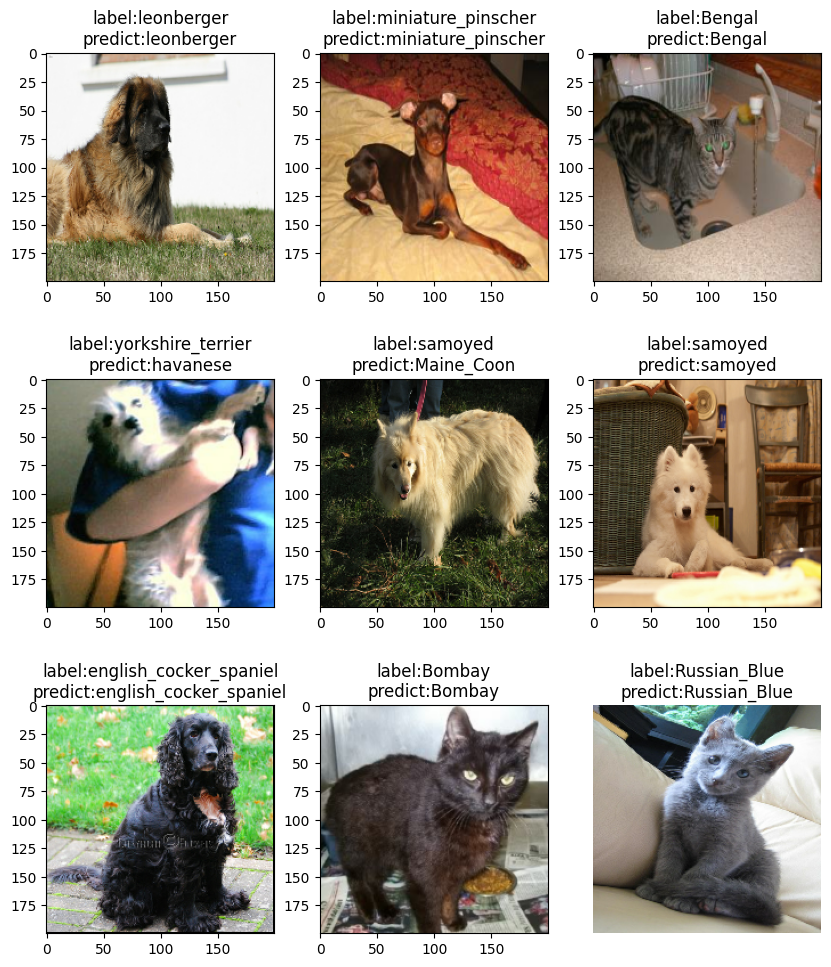

In [6]:
import matplotlib.pyplot as plt
labels = val_data.class_names

plt.figure(figsize=(10, 12))
predict_dataset()

これで、modelの部分を推論APIに置き換えることができました。

## Gradioを使って犬種/猫種判別を行うデモアプリを作成する

model部分のAPI化ができたので、機械学習を使った簡単なデモアプリを作ってみましょう。

まず、お手軽にML系のwebアプリケーションが作成できるgradioをinstallします。

In [7]:
!pip install gradio

In [8]:
import gradio as gr

上記ImportErrorがでた場合は、kernelをrestartして、<b>bashコマンド以降のセルを改めて実行してみてください。</b>

完了したら、デモアプリを作成してみましょう。  
コード実行ができたら、public URLを確認してみてください。

In [9]:
labels = val_data.class_names

def predict(img):
    img = img / 255.0
    img = np.expand_dims(image, 0)    
    img = img.tolist()
    pred = predict_json(img)[0]
    confidences = {labels[i]: pred[i] for i in range(len(labels))}    
    return confidences

demo = gr.Interface(predict, gr.Image(), outputs=gr.Label(num_top_classes=5))

# <todo> ""部分に独自のuserとpasswordを入力してください。
# share=Trueになっていると、public URLとして公開されるため、必ず各自でpassを設定して入るようにしてください。
demo.launch(share=True, auth=("test", "test"))

Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://8cfea1a62802fb3bc4.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


犬種/猫種判定アプリが作れていましたでしょうか。  
データセットにない犬、猫などは、  
犬は、https://www.min-inuzukan.com/  
猫は、https://www.min-nekozukan.com/  
にあるので、これらを参考にしつつ正しく判別できるか試してみてください。 